# Lab 2
Долгих Елизавета

Start - 4 November 2025.\
Deadline - 23 November 2025, 23:30.

*All solutions must be in a <ins>single Colab Jupyter Notebook file</ins> and uploaded to the <ins>LMS portal</ins> as the link to __your__ completed notebook in Colab.*

In [ ]:
import unittest

#import numpy
import pandas  as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm
import statsmodels.api as sm
from matplotlib.pyplot import figure
from datetime import date, timedelta
from typing import List, Tuple
from math import exp, log, sqrt
import os
import io

import numpy as np

### Вводная часть

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving AAPL.csv to AAPL.csv
Saving GCurve.csv to GCurve.csv


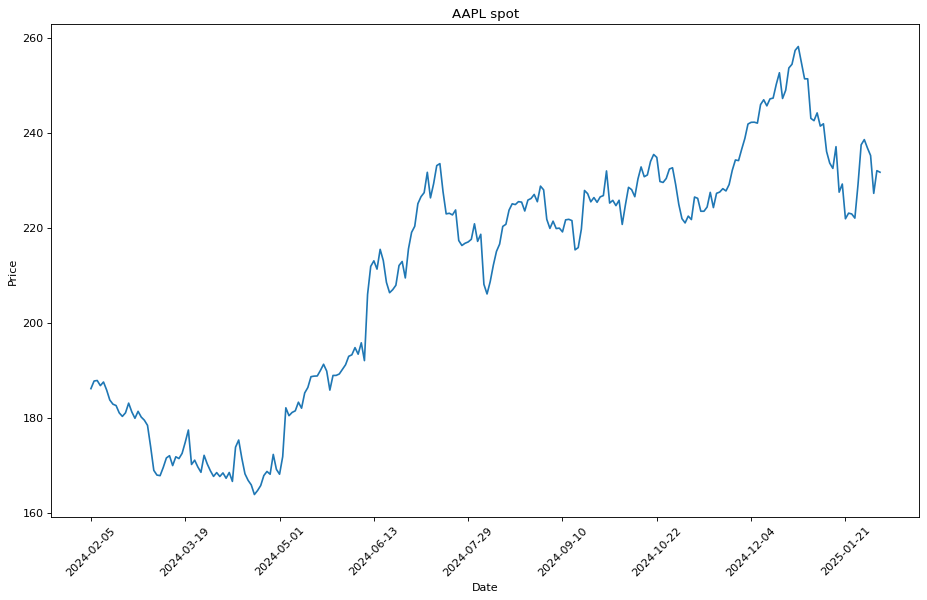

In [ ]:
underlying = "AAPL"

indexValues = pd.read_csv(io.StringIO(uploaded['AAPL.csv'].decode('utf-8')))
indexDates = indexValues['Date'].to_list()
# indexValues = indexValues.set_index("Date", drop=True)
quotes = indexValues["underlyingPrice"]

figure(figsize=(14, 8), dpi=80)

plt.plot(indexValues["underlyingPrice"])
plt.title(f"{underlying} spot")
plt.xlabel("Date")
plt.ylabel("Price")


step = 30
positions = range(0, len(indexDates), step)
labels = [indexDates[i] for i in positions]

plt.xticks(ticks=positions, labels=labels, rotation=45)
plt.show()


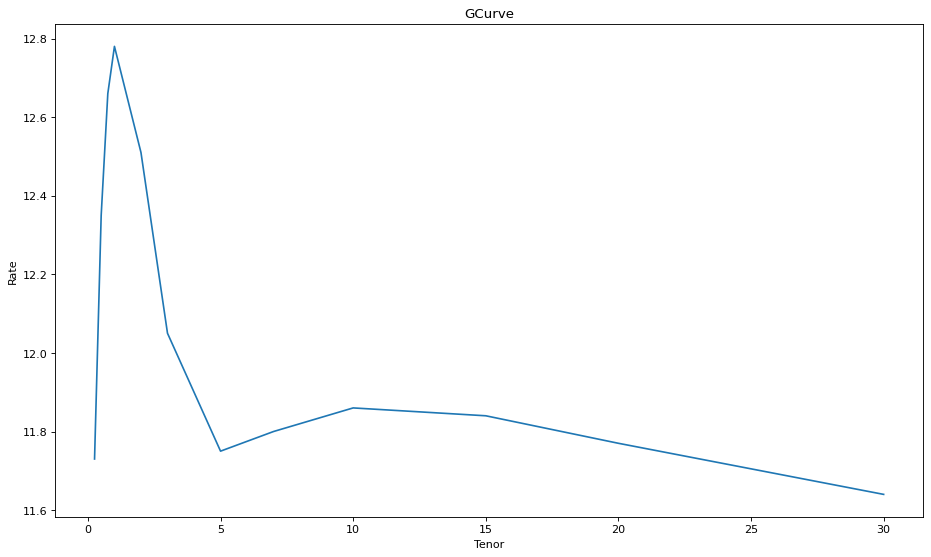

In [ ]:
curveValues = pd.read_csv(io.StringIO(uploaded['GCurve.csv'].decode('utf-8')))
#curveValues = pd.read_csv('GCurve.csv')
curveDates = curveValues['date'].to_list()

figure(figsize=(14, 8), dpi=80)

plt.plot(
    curveValues.columns[2:].astype(float),
    curveValues.iloc[0, 2:].astype(float)
)
plt.title("GCurve")
plt.xlabel("Tenor")
plt.ylabel("Rate")

plt.show()

## Geometirc Asian call option

Consider a geometric Asian call option with payoff at maturity $T$ given by:
\begin{equation*}
    \left( \exp\left(\frac{1}{T} \int_0^T \ln S_u \, du\right) - K \right)^+
\end{equation*}
where $K$ is the strike and $S_u$ denotes the price of the underlying asset price at time $u$. Assume the underlying asset price follows the dynamics:
\begin{equation*}
    dS_t = r S_t dt + \sigma(t) S_t d\widetilde{W}_t, \quad S_0 = s_0
\end{equation*}
where
*   $r$ is the constant interest rate;
*   $\sigma(t)$ is a deterministic function of time.

## Задача 1: Аналитическая формула цены геометрического азиатского опциона

1. (1 point) Define the process:
\begin{equation*}
    Y_t = \int_0^t \ln S_u \, du.
\end{equation*}
Then the option price at time $t$ is given by
\begin{equation*}
    V(t, S_t, Y_t) = e^{-r(T-t)} \mathbb{E}_t \left[ \left( e^{Y_T / T} - K \right)^+ \right].
\end{equation*}
Find the price of this option at arbitrary time $t$ and express this price as a function $V(t, S_t, Y_t)$. \
Ensure your formula reduces to the time 0 pricing formula from the seminar.

Идея решения:
1. Выплата опциона зависит от $Y_T = \int_0^T \ln S_u du$. В момент $t$ интеграл разбивается на две части: известную (накопленную) $Y_t = \int_0^t \ln S_u du$ и будущую стохастическую $\int_t^T \ln S_u du$.
2. В риск-нейтральной мере $\mathbb{Q}$ логарифм цены $\ln S_u$ (для $u > t$) распределен нормально. Интеграл от гауссовского процесса также является гауссовской случайной величиной.
3. Опцион сводится к выплате вида $(C \cdot e^{\xi} - K)^+$, где $\xi$ — нормальная случайная величина, а $C$ — константа, зависящая от $Y_t$.
4. Используем формулу для матожидания от логнормальной величины (аналог формулы Блэка-Шоулза).

**Решение:**

С учетом введенных обозначений $Y_t = \int_0^t \ln S_u du$, выплата опциона в момент $T$ записывается как:
$$\left( \exp\left( \frac{Y_t}{T} + \frac{1}{T} \int_t^T \ln S_u du \right) - K \right)^+$$

В риск-нейтральной мере $\mathbb{Q}$ динамика актива задается уравнением (при $r = \text{const}$ и детерминированной волатильности $\sigma(t)$):
$$dS_t = r S_t dt + \sigma(t) S_t d\tilde{W}_t$$
Отсюда динамика логарифма цены (выводили в том числе на семинаре 6):
$$\ln S_u = \ln S_t + \int_t^u \left( r - \frac{1}{2}\sigma^2(s) \right) ds + \int_t^u \sigma(s) d\tilde{W}_s, \quad u \ge t$$


Обозначим $I_t = \int_t^T \ln S_u du$. Найдем условное математическое ожидание $M(t) = \mathbb{E}_t^{\mathbb{Q}}[I_t]$ и дисперсию $D(t) = \text{Var}_t^{\mathbb{Q}}[I_t]$.

**1. Математическое ожидание $M(t)$:**
$$I_t = \int_t^T \ln S_u du = \int_t^T \left( \ln S_t + \int_t^u \left(r - \frac{1}{2}\sigma^2(s)\right) ds  + \int_t^u \sigma(s) d\tilde{W}_s \right) du$$
Меняем порядок интегрирования во втором и третьем слагаемым (по аналогии с тем, что делали на семинаре, применяем теорему Фубини и теорему Фубини для стохастических интегралов):\
$\textbf{Детермин. часть} = \int_t^T \int_t^u \ldots ds du = \int_t^T \int_s^T \ldots du ds = \int_t^T (T-s) \ldots ds$\
\
$\textbf{Стохаст. часть} = \int_t^T \int_t^u \sigma(s) d\tilde{W}_s du = \int_t^T \int_s^T  \sigma(s)du d\tilde{W}_s = \int_t^T (T-s) \sigma(s) d\tilde{W}_s  \sim \mathcal{N}\left( 0, \int_t^T (T-s)^2 \sigma ^2(s) ds  \right)  $.\
В итоге,
$$ I_t = (T-t)\ln S_t + \int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds + \text{Стохаст. часть}$$
Поэтому можем посчитать мат.ожидание:
$$M(t) = \mathbb{E}_t^{\mathbb{Q}}[I_t] = (T-t)\ln S_t + \int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds$$

**2. Дисперсия $D(t)$:** \
Из вида $I_t$ и найденного распределения стохаст. части сразу находим:
$$D(t) = \int_t^T (T-s)^2 \sigma^2(s) ds$$

**3. Цена опциона $V(t, S_t, Y_t)$:** \
Величина $G_T = \exp\left( \frac{Y_t + I_t}{T} \right)$ имеет логнормальное распределение.
$$\ln G_T \sim \mathcal{N}\left( \frac{Y_t + M(t)}{T}, \frac{D(t)}{T^2} \right)$$
Обозначим параметры логнормального распределения как $\mu_G = \frac{Y_t + M(t)}{T}$ и $\sigma_G^2 = \frac{D(t)}{T^2}$.

Согласно формуле оценки для логнормальных активов (аналог формулы Блэка-Шоулза), цена опциона равна:
$$V(t, S_t, Y_t) = e^{-r(T-t)} \left( e^{\mu_G + \frac{1}{2}\sigma_G^2} N(d_1) - K N(d_2) \right)$$
где
$$d_1 = \frac{\mu_G + \sigma_G^2 - \ln K}{\sigma_G}, \quad d_2 = d_1 - \sigma_G$$

Посчитаем $d_1$ явно:
$$ d_1 = \frac{\frac{Y_t}{T} + \frac{T-t}{T}\ln S_t + \frac{1}{T}\int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds + \sigma_G^2(t) - \ln K}{\sigma_G(t)} $$

Тогда **ответ**:
$$V(t, S_t, Y_t) = e^{-r(T-t)} \left( e^{\mu_G + \frac{1}{2}\sigma_G^2} N(d_1) - K N(d_2) \right)$$
где
$$ d_1 = \frac{\frac{Y_t}{T} + \frac{T-t}{T}\ln S_t + \frac{1}{T}\int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds + \sigma_G^2(t) - \ln K}{\sigma_G(t)} $$
$$ d_2 = d_1 - \sigma_G (t)$$

$$\sigma_G^2 (t)= \frac{D(t)}{T^2} = \frac{\int_t^T (T-s)^2 \sigma^2(s) ds}{T^2}$$
$$\mu_G (t) = \frac{Y_t + M(t)}{T} = \frac{Y_t + (T-t)\ln S_t + \int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds}{T}$$

Эта формула согласуется с решением из семинара.

## Задача 2: Проверка уравнения Фейнмана-Каца

2. (2 points) Verify by direct substitution that this price $V(t, s, y)$ for the geometric Asian option satisfies the Feynman-Kac equation
\begin{equation*}
    \frac{\partial V}{\partial t} + r s \frac{\partial V}{\partial s} + \ln s \frac{\partial V}{\partial y} + \frac{1}{2} \sigma^2(t) s^2 \frac{\partial^2 V}{\partial s^2} - r V = 0.
\end{equation*}

### 1. Подготовка формулы
Для удобства дифференцирования перепишем результат Задачи 1, введя вспомогательную переменную $F_t$ (форвардная цена геометрического среднего).

Введем обозначение времени до экспирации $\tau = T-t$.
Из Задачи 1 мы получили:
$$V = e^{-r\tau} \left( F_t N(d_1) - K N(d_2) \right)$$

Где $F_t = \exp\left( \mu_G + \frac{1}{2}\sigma_G^2 \right)$. В явном виде:
$$F_t = S^{\frac{\tau}{T}} \exp\left( \frac{Y_t}{T} + \frac{1}{T}\int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds + \frac{1}{2T^2}\int_t^T (T-s)^2 \sigma^2(s) ds \right)$$

Параметры $d_1, d_2$:
$$d_1 = \frac{\ln F_t - \ln K}{\sigma_G} + \frac{1}{2}\sigma_G, \quad d_2 = d_1 - \sigma_G$$
$$\sigma_G = \frac{1}{T} \sqrt{\int_t^T (T-s)^2 \sigma^2(s) ds}$$

Также нам понадобится важное тождество для формул типа Блэка-Шоулза:
$$F_t N'(d_1) = K N'(d_2)$$
*Доказательство тождества:* $\frac{N'(d_1)}{N'(d_2)} = \frac{e^{-d_1^2/2}}{e^{-(d_1-\sigma_G)^2/2}} = e^{d_1 \sigma_G - \sigma_G^2/2} = \exp(\ln(F_t/K) + \sigma_G^2/2 - \sigma_G^2/2) = \frac{F_t}{K}$.

---

### 2. Вычисление частных производных

#### А. Производные по $S$ (Delta и Gamma)
Заметим, что $S$ входит только в множитель $S^{\tau/T}$ внутри $F_t$. Параметр $\sigma_G$ от $S$ не зависит.
Найдем $\frac{\partial F_t}{\partial S}$:
$$\frac{\partial F_t}{\partial S} = F_t \cdot \frac{\partial (\ln F_t)}{\partial S} = F_t \cdot \frac{\partial}{\partial S}\left( \frac{\tau}{T} \ln S \right) = F_t \frac{\tau}{TS}$$

Теперь дифференцируем $V$:
$$\frac{\partial V}{\partial S} = e^{-r\tau} \left( \frac{\partial F_t}{\partial S} N(d_1) + F_t N'(d_1) \frac{\partial d_1}{\partial S} - K N'(d_2) \frac{\partial d_2}{\partial S} \right)$$
Так как $\partial_S d_1 = \partial_S d_2$ (разница константа), а $F_t N'(d_1) - K N'(d_2) = 0$, то члены с производными от $d$ сокращаются:
$$Delta = \frac{\partial V}{\partial S} = e^{-r\tau} N(d_1) \frac{\partial F_t}{\partial S} = e^{-r\tau} N(d_1) F_t \frac{\tau}{TS}$$

Найдем вторую производную (Gamma):
$$\frac{\partial^2 V}{\partial S^2} = \frac{\partial}{\partial S} \left( e^{-r\tau} N(d_1) F_t \frac{\tau}{TS} \right) = e^{-r\tau} \frac{\tau}{T} \frac{\partial}{\partial S} \left( \frac{F_t N(d_1)}{S} \right)$$
Используем правило производной произведения:
$$\frac{\partial}{\partial S} \left( \frac{F_t N(d_1)}{S} \right) = -\frac{F_t N(d_1)}{S^2} + \frac{1}{S} \left( \frac{\partial F_t}{\partial S} N(d_1) + F_t N'(d_1) \frac{\partial d_1}{\partial S} \right)$$
Подставим $\frac{\partial F_t}{\partial S} = F_t \frac{\tau}{TS}$ и $\frac{\partial d_1}{\partial S} = \frac{1}{\sigma_G} \frac{\partial \ln F_t}{\partial S} = \frac{\tau}{TS\sigma_G}$:
$$= \frac{F_t}{S^2} \left[ -N(d_1) + \frac{\tau}{T} N(d_1) + N'(d_1) \frac{\tau}{T\sigma_G} \right]$$
Итого:
$$Gamma = \frac{\partial^2 V}{\partial S^2} = e^{-r\tau} \frac{F_t}{S^2} \frac{\tau}{T} \left[ \left(\frac{\tau}{T} - 1\right) N(d_1) + \frac{\tau}{T\sigma_G} N'(d_1) \right]$$

#### B. Производная по $Y$
$Y$ входит линейно в показатель экспоненты $F_t$.
$$\frac{\partial F_t}{\partial Y} = F_t \frac{1}{T}$$
Аналогично Дельте (производные $d$ сокращаются):
$$\frac{\partial V}{\partial Y} = e^{-r\tau} N(d_1) \frac{\partial F_t}{\partial Y} = e^{-r\tau} N(d_1) F_t \frac{1}{T}$$

#### C. Производная по времени $t$ (Theta)
$$V = e^{-r\tau} (\dots) \implies \frac{\partial V}{\partial t} = rV + e^{-r\tau} \frac{\partial}{\partial t} \left( F_t N(d_1) - K N(d_2) \right)$$
Раскроем скобку производной:
$$(\dots)'_t = \frac{\partial F_t}{\partial t} N(d_1) + F_t N'(d_1) \frac{\partial d_1}{\partial t} - K N'(d_2) \frac{\partial d_2}{\partial t}$$
Заметим, что $\frac{\partial d_2}{\partial t} = \frac{\partial d_1}{\partial t} - \frac{\partial \sigma_G}{\partial t}$. Используя тождество $F_t N'(d_1) = K N'(d_2)$, получаем:
$$(\dots)'_t = \frac{\partial F_t}{\partial t} N(d_1) + K N'(d_2) \frac{\partial \sigma_G}{\partial t}$$

Найдем вспомогательные производные по $t$:
1.  $\frac{\partial \tau}{\partial t} = -1$ .
2.  Квадрат волатильности
$$\sigma_G^2(t) = \frac{1}{T^2} \int_t^T (T-s)^2 \sigma^2(s) ds$$
$$
    \frac{\partial \sigma_G^2}{\partial t} = -\frac{1}{T^2} (T-t)^2 \sigma^2(t) = -\frac{\tau^2}{T^2} \sigma^2(t)
    $$
    $$
    \frac{\partial \sigma_G}{\partial t} = \frac{1}{2\sigma_G} \frac{\partial \sigma_G^2}{\partial t} = -\frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G}
$$
3.  Логарифм $F_t$:
$$
    \ln F_t = \frac{\tau}{T} \ln S + \frac{Y_t}{T} + \frac{1}{T}\int_t^T (T-s)(r - \frac{1}{2} \sigma^2) ds + \frac{1}{2}\sigma_G^2
$$
$$
\frac{\partial \ln F_t}{\partial t} = -\frac{\ln S}{T} - \frac{1}{T}(T-t)(r - \frac{1}{2} \sigma^2(t)) + \frac{1}{2} \frac{\partial \sigma_G^2}{\partial t} = -\frac{\ln S}{T} - \frac{\tau r}{T} + \frac{ \tau \sigma^2(t)}{2T} - \frac{\tau^2 \sigma^2(t)}{2T^2}
$$
$$
\frac{\partial F_t}{\partial t} = F_t \frac{\partial \ln F_t}{\partial t}
$$

Итого $\frac{\partial V}{\partial t}$:
$$
\frac{\partial V}{\partial t} = rV + e^{-r\tau} \left[ N(d_1) F_t \left( -\frac{\ln S}{T} - \frac{\tau r}{T} + \frac{\tau \sigma^2(t)}{2T} - \frac{\tau^2 \sigma^2(t)}{2T^2} \right) - N'(d_1) F_t \frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G} \right]
$$

---

### 3. Подстановка в PDE
Сгруппируем слагаемые в уравнении по типу множителей: $e^{-r\tau} F_t N(d_1)$ и $e^{-r\tau} F_t N'(d_1)$.

**Слагаемые с $N(d_1)$:**
1.  Из $\frac{\partial V}{\partial t}$: $\quad -\frac{\ln S}{T} - \frac{\tau r}{T} + \frac{\tau \sigma^2(t)}{2T} - \frac{\tau^2 \sigma^2(t)}{2T^2}$ \
(В выражении $\partial V / \partial t = rV + \dots$ первое слагаемое $rV$ полностью уходит с последним слагаемым $-rV$ в PDE. Смотрим только на скобку.)
2.  Из $rS \frac{\partial V}{\partial S}$: $\quad rS \cdot \frac{\tau}{TS} = \frac{r \tau}{T}$.
3.  Из $\ln S \frac{\partial V}{\partial Y}$: $\quad \ln S \cdot \frac{1}{T} = \frac{\ln S}{T}$.
4.  Из $\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}$: $\quad \frac{1}{2}\sigma^2 S^2 \cdot \frac{1}{S^2} \frac{\tau}{T} (\frac{\tau}{T} - 1) = \frac{\sigma^2 \tau^2}{2T^2} - \frac{\sigma^2 \tau}{2T}$.

**Сумма коэффициентов при $N(d_1)$:**
$$\left( -\frac{\ln S}{T} - \frac{\tau r}{T} + \frac{\tau \sigma^2}{2T} - \frac{\tau^2 \sigma^2}{2T^2} \right) + \left( \frac{r \tau}{T} \right) + \left( \frac{\ln S}{T} \right) + \left( \frac{\tau^2 \sigma^2}{2T^2} - \frac{\tau \sigma^2}{2T} \right)$$
Все слагаемые взаимно уничтожаются. Сумма равна **0**.

**Слагаемые с $N'(d_1)$:**
1.  Из $\frac{\partial V}{\partial t}$: $\quad -\frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G}$.
2.  Из $\frac{1}{2}\sigma^2 S^2 \frac{\partial^2 V}{\partial S^2}$: $\quad \frac{1}{2}\sigma^2 S^2 \cdot \frac{1}{S^2} \frac{\tau}{T} \frac{\tau}{T \sigma_G} = \frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G}$.

**Сумма коэффициентов при $N'(d_1)$:**
$$-\frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G} + \frac{\tau^2 \sigma^2(t)}{2 T^2 \sigma_G} = \mathbf{0}$$

### Вывод
Подстановка вычисленных производных обращает левую часть уравнения Фейнмана-Каца в ноль. Следовательно, полученная аналитическая формула $V(t, S, Y)$ является верным решением задачи.

## Задача 3: Декомпозиция ошибки хеджирования

3. (2 points) Let $X$ be the financial result of the next hedging strategy:
*   hold position of size $\Delta_t^h$ in the underlying asset at time $t$,
*   borrow needed or lend excessive money at instantaneous rate $r_t^f$ at time $t$. \
Find the decomposition of the hedging error for this option in the Black-Scholes-Merton model with time-dependent volatility and with volatility recalibration.

**Решение:**

#### 1. Дифференциал ошибки хеджирования ($dZ_t$)

Портфель является самофинансируемым. Его изменение складывается из дохода от переоценки актива и процентного дохода/расхода на денежный остаток $(X_t - \Delta_t^h S_t)$.
Динамика портфеля:
$$dX_t = \Delta_t^h dS_t + r_t^f (X_t - \Delta_t^h S_t) dt$$

Введем дисконтный фактор $D_t = \exp\left(-\int_0^t r_u^f du\right)$, соответствующий ставке финансирования (то есть $d D_t = -r_t^f D_t dt $).
Найдем дифференциал дисконтированной стоимости портфеля $d(D_t X_t)$:
$$d(D_t X_t) = D_t (-r_t^f X_t dt + dX_t) = D_t \left( -r_t^f X_t dt + \Delta_t^h dS_t + r_t^f X_t dt - r_t^f \Delta_t^h S_t dt \right)$$
$$d(D_t X_t) = D_t \Delta_t^h (dS_t - r_t^f S_t dt) = \Delta_t^h dD_tS_t$$

#### 2. Динамика цены опциона ($V_t$)
Цена опциона $V(t, S_t, Y_t, \sigma_t)$ рассчитывается в модели Блэка-Шоулза с использованием:
* Модельной безрисковой ставки $r$ (которая может отличаться от $r_t^f$).
* Модельной волатильности $\sigma_{model}(t)$.

Из задания 2, функция цены $V$ удовлетворяет уравнению Фейнмана-Каца (PDE):
$$
\frac{\partial V}{\partial t} + r S \frac{\partial V}{\partial S} + \ln S \frac{\partial V}{\partial Y} + \frac{1}{2} \sigma_{model}^2(t) S^2 \frac{\partial^2 V}{\partial S^2} - rV = 0
$$

Применим формулу Ито к $V_t$, учитывая стохастическую природу $\sigma_t$ (параметр калибровки):
$$dV_t = \frac{\partial V}{\partial t} dt + \frac{\partial V}{\partial S} dS_t + \frac{\partial V}{\partial Y} dY_t + \frac{\partial V}{\partial \sigma} d\sigma_t + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} (dS_t)^2 + + \frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t + + \frac{1}{2} \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2$$

Выразим $\frac{\partial V}{\partial t}$ из PDE и подставим в $dV_t$:
$$dV_t = \left( r(V - S \frac{\partial V}{\partial S}) - \frac{1}{2} \sigma_{model}^2 S^2 \frac{\partial^2 V}{\partial S^2} \right) dt + \frac{\partial V}{\partial S} dS_t + \frac{\partial V}{\partial \sigma} d\sigma_t + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} (dS_t)^2 + \frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t + \frac{1}{2} \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2$$

Теперь найдем дифференциал дисконтированной цены $d(D_t V_t)$:
$$d(D_t V_t) = D_t (-r_t^f V_t dt + dV_t)$$

Группируем слагаемые, выделяя разницу ставок $(r - r_t^f)$ и разницу дисперсий:
$$
d(D_t V_t) = D_t [ -r_t^f V_t dt + rV dt - r S \frac{\partial V}{\partial S} dt + \frac{\partial V}{\partial S} dS_t +$$
$$ + \frac{1}{2} \frac{\partial^2 V}{\partial S^2} ((dS_t)^2 - \sigma_{model}^2 S^2 dt) + \frac{\partial V}{\partial \sigma} d\sigma_t + \frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t + \frac{1}{2} \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2 ]
$$

Добавим и вычтем $r_t^f S \frac{\partial V}{\partial S} dt$:
$$
d(D_t V_t) = D_t \frac{\partial V}{\partial S} (dS_t - r_t^f S dt) + D_t (r - r_t^f)(V - S \frac{\partial V}{\partial S}) dt + \frac{1}{2} D_t \frac{\partial^2 V}{\partial S^2} ((dS_t)^2 - \sigma_{model}^2 S^2 dt) + $$
$$ + D_t \frac{\partial V}{\partial \sigma} d\sigma_t + D_t \frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t + \frac{1}{2} D_t\frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2
$$

$$
d(D_t V_t) = \frac{\partial V}{\partial S} dD_tS_t + D_t (r - r_t^f)(V - S \frac{\partial V}{\partial S}) dt + \frac{1}{2} D_t \frac{\partial^2 V}{\partial S^2} ((dS_t)^2 - \sigma_{model}^2 S^2 dt) + $$
$$+ D_t \frac{\partial V}{\partial \sigma} d\sigma_t + D_t\frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t + \frac{1}{2}D_t \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2
$$

#### 3. Ошибка хеджирования ($Z_t$)
Ошибка хеджирования $Z_t = X_t - V_t$. Тогда $d(D_t Z_t) = d(D_t X_t) - d(D_t V_t)$.
Вычитая полученные выражения, получаем итоговую декомпозицию:
component

$$
d(D_t Z_t) = \underbrace{D_t \left( \Delta_t^h - \frac{\partial V}{\partial S} \right) (dS_t - r_t^f S_t dt)}_{\textbf{Delta Hedge Error}}
$$
$$
+ \underbrace{D_t (r_t^f - r) \left( V_t - S_t \frac{\partial V}{\partial S} \right) dt}_{\textbf{Funding / Rate P\&L}}
$$
$$
+ \underbrace{\frac{1}{2} D_t \frac{\partial^2 V}{\partial S^2} (\sigma_{model}^2(t)S^2_t dt - (dS_t)^2)}_{\textbf{Gamma P\&L}}
+ \underbrace{D_t \frac{\partial V}{\partial \sigma} \left( \frac{\partial \sigma_t}{\partial t} dt - d\sigma_t \right)}_{\textbf{Vega / Recalibration P\&L}}
$$
$$
- \underbrace{D_t\frac{\partial^2 V}{\partial S \partial \sigma} dS_t d\sigma_t }_{\textbf{Vanna P\&L}} - \underbrace{\frac{1}{2}D_t \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_t)^2}_{\textbf{Volga P\&L}}
$$



#### 4. Интегрирование уравнения

Интегрируя от $0$ до $t$ и умножая на $1/D_t = \exp(\int_0^t r_u^f du)$, получаем выражение для $Z_t$:

#### 5. Итоговая формула декомпозиции

$$
Z_t = \underbrace{\frac{Z_0}{D_t}}_{\textbf{Premium Component}} + \underbrace{ \int_0^t \frac{D_u}{D_t} \left( \Delta_u^h - \frac{\partial V}{\partial S} \right) (dS_u - r_u^f S_u du)}_{\textbf{Delta Component}}
$$
$$
+ \underbrace{\int_0^t \frac{D_u}{D_t} (r_u^f - r) \left( V_u - S_u \frac{\partial V}{\partial S} \right) du}_{\textbf{Funding Component}}
$$
$$
+ \underbrace{\frac{1}{2} \int_0^t \frac{D_u}{D_t} \frac{\partial^2 V}{\partial S^2} (\sigma_{model}^2(u)S^2_u - (dS_u)^2) du}_{\textbf{Gamma Component}}
$$
$$
+ \underbrace{\int_0^t \frac{D_u}{D_t} \frac{\partial V}{\partial \sigma} \left( \frac{\partial \sigma_u}{\partial u} du - d\sigma_u \right)}_{\textbf{Vega Component}}
$$
$$
- \underbrace{\int_0^t \frac{D_u}{D_t} \frac{\partial^2 V}{\partial S \partial \sigma} dS_u d\sigma_u}_{\textbf{Vanna Component}}
- \underbrace{\int_0^t \frac{1}{2} \frac{D_u}{D_t} \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_u)^2}_{\textbf{Volga Component}}
$$

где:
* $\sigma_{model}(u)$ — значение волатильности, использованное в прайсере в момент $u$.
* $d\sigma_u$ — стохастическое изменение прогноза волатильности (из GARCH).


## Задача 4: Расчет цены при $\sigma(t)$ из GARCH(1,1)

**Suppose $\sigma(t)$ represent a volatility forecast from the GARCH(1,1) model.**

4. (0.5 point) Implement the valuation of a geometric Asian call option price. \
Consider the interest rate is constant. Assume that the parameters $\alpha$, $\beta$, $\sigma_L$, and the current volatility estimate are known.

**Итоговая формула из задачи 1**:
$$V(t, S_t, Y_t) = e^{-r(T-t)} \left( e^{\mu_G + \frac{1}{2}\sigma_G^2} N(d_1) - K N(d_2) \right)$$
где
$$ d_1 = \frac{\frac{Y_t}{T} + \frac{T-t}{T}\ln S_t + \frac{1}{T}\int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds + \sigma_G^2(t) - \ln K}{\sigma_G(t)} $$
$$ d_2 = d_1 - \sigma_G (t)$$

$$\sigma_G^2 (t)= \frac{D(t)}{T^2} = \frac{\int_t^T (T-s)^2 \sigma^2(s) ds}{T^2}$$
$$\mu_G (t) = \frac{Y_t + M(t)}{T} = \frac{Y_t + (T-t)\ln S_t + \int_t^T (T-s)\left(r - \frac{1}{2}\sigma^2(s)\right) ds}{T}$$
$Y_t = \int_0^t \ln S_u du$

Для реализации нам необходимо вычислить интегралы от детерминированной функции волатильности GARCH(1,1) в непрерывном времени.

Согласно Лекции 6, слайд 27, прогноз волатильности (на время $u$, скалиброванный в момент $t$, $t \leq u$) имеет вид:
$$
\sigma_t^2(u) = \sigma_L^2 + e^{-\lambda(u-t)}(\sigma_t^2(t) - \sigma_L^2)
$$
где $\lambda = \frac{\ln(1/(\alpha+\beta))}{\Delta t}$.

Обозначения для удобства:\
$\tau = T - t$ (время до экспирации)\
$x = u - t$ (время от текущего момента)\
$\theta = \sigma_L^2$\
$\delta(t) = \sigma^2(t) - \sigma_L^2$ \
Тогда $\sigma^2(t+x) = \theta + \delta(t) e^{-\lambda x}$.

### Вычисление Интеграла 1 (для среднего)

$$
\int_t^T (T-u) \sigma^2(u) \, du = \int_0^\tau (\tau - x) (\theta + \delta(t) e^{-\lambda x}) \, dx
$$

Разбиваем на два слагаемых:

1. $\int_0^\tau (\tau - x) \theta \, dx = \theta \left[ \tau x - \frac{x^2}{2} \right]_0^\tau = \frac{\theta \tau^2}{2}$

2. $\int_0^\tau (\tau - x) \delta(t) e^{-\lambda x} \, dx$. Интегрируем по частям, получаем: $\delta(t) \left( \frac{\tau}{\lambda} - \frac{1}{\lambda^2}(1 - e^{-\lambda \tau}) \right)$.

### Вычисление Интеграла 2 (для дисперсии)

$$
\int_t^T (T-u)^2 \sigma^2(u) \, du = \int_0^\tau (\tau - x)^2 (\theta + \delta(t) e^{-\lambda x}) \, dx
$$

Разбиваем:

1. $\int_0^\tau (\tau - x)^2 \theta \, dx = \theta \left[ - \frac{(\tau-x)^3}{3} \right]_0^\tau = \frac{\theta \tau^3}{3}$

2. $\int_0^\tau (\tau - x)^2 \delta(t) e^{-\lambda x} \, dx$. Интегрируя по частям дважды, получаем: $\delta(t) \left( \frac{\tau^2}{\lambda} - \frac{2\tau}{\lambda^2} + \frac{2}{\lambda^3}(1 - e^{-\lambda \tau}) \right)$

In [ ]:
def geometric_asian_call_price(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252):
    """
    Вычисляет цену геометрического азиатского колл-опциона
    с использованием GARCH(1,1) прогноза волатильности.

    Параметры:
    S : float : Текущая цена актива
    K : float : Страйк
    T : float : Время экспирации (в годах)
    t : float : Текущее время (в годах)
    r : float : Безрисковая ставка
    Y_t : float : Накопленный интеграл логарифма цены (int_0^t ln(S_u) du)
    sigma_curr : float : Текущая мгновенная волатильность
    sigma_L : float : Долгосрочная волатильность
    alpha, beta : float : Параметры GARCH
    dt : float : Шаг времени для параметров GARCH (обычно 1/252)
    """

    tau = T - t

    # Если опцион истек или истекает сейчас
    if tau <= 1e-9:
        payoff = np.exp(Y_t / T) - K
        return max(payoff, 0.0)

    # 1. Параметры GARCH
    # Скорость возврата к среднему (Mean reversion speed)
    # lambda = ln(1 / (alpha + beta)) / dt
    lam = np.log(1 / (alpha + beta)) / dt

    # Компоненты дисперсии
    theta = sigma_L**2
    delta = sigma_curr**2 - sigma_L**2

    # Вспомогательные переменные для экспонент
    exp_lam_tau = np.exp(-lam * tau)
    term_1_minus_exp = 1 - exp_lam_tau

    # 2. Вычисление интегралов

    # Интеграл 1: int_t^T (T-u) sigma^2(u) du
    # Используется для вычисления сноса (drift correction)
    # Аналитическое значение: theta * tau^2 / 2 + delta * (tau/lam - (1-e^-lam*tau)/lam^2)
    int_1 = (theta * tau**2) / 2 + delta * (tau / lam - term_1_minus_exp / lam**2)

    # Интеграл 2: int_t^T (T-u)^2 sigma^2(u) du
    # Это и есть условная дисперсия D(t) для стохастической части интеграла I_t
    # Аналитическое значение: theta * tau^3 / 3 + delta * (...)
    term_B_int = (tau**2 / lam) - (2 * tau / lam**2) + (2 / lam**3) * term_1_minus_exp
    D_t = (theta * tau**3) / 3 + delta * term_B_int

    # 3. Параметры распределения среднего (Geometric Average parameters)

    # Мат. ожидание M(t) = E_t[ integral_t^T ln S_u du ]
    # M(t) = (T-t)ln S_t + r(T-t)^2 / 2 - 0.5 * int_1
    # Слагаемое r * integral(T-u) du дает r * tau^2 / 2
    M_t = tau * np.log(S) + (r * tau**2) / 2 - 0.5 * int_1

    # Параметры логнормального распределения величины G_T
    # mu_G = (Y_t + M(t)) / T
    # sigma_G^2 = D(t) / T^2
    mu_G = (Y_t + M_t) / T
    sigma_G_sq = D_t / (T**2)
    sigma_G = np.sqrt(sigma_G_sq)

    # 4. Формула Блэка-Шоулза
    d1 = (mu_G + sigma_G_sq - np.log(K)) / sigma_G
    d2 = d1 - sigma_G

    # Форвардная цена геометрического среднего
    F_t = np.exp(mu_G + 0.5 * sigma_G_sq)

    # Цена опциона
    # V = e^{-r*tau} * (F_t * N(d1) - K * N(d2))
    price = np.exp(-r * tau) * (F_t * norm.cdf(d1) - K * norm.cdf(d2))

    return price

In [ ]:
# Пример вызова (с произвольными данными для проверки)
S_test = 100
K_test = 100
T_test = 1.0
t_test = 0.0
r_test = 0.05
Y_0 = 0 # В начале периода накопленный логарифм равен 0
sigma_curr_test = 0.25
sigma_L_test = 0.2
alpha_test = 0.1
beta_test = 0.85

price = geometric_asian_call_price(S_test, K_test, T_test, t_test, r_test, Y_0,
                                   sigma_curr_test, sigma_L_test, alpha_test, beta_test)
print(f"Option Price: {price:.4f}")

Option Price: 5.7804


## Задача 5: Вычисление дельты и гаммы

5. (0.5 point) Compute the delta and gamma of the geometric Asian option.

Напомним, что $F_t = \exp\left( \mu_G + \frac{1}{2}\sigma_G^2 \right)$.
$$Delta = \frac{\partial V}{\partial S} = e^{-r\tau} N(d_1) F_t \frac{\tau}{TS}$$
$$Gamma = \frac{\partial^2 V}{\partial S^2} = e^{-r\tau} \frac{F_t}{S^2} \frac{\tau}{T} \left[ \left(\frac{\tau}{T} - 1\right) N(d_1) + \frac{\tau}{T\sigma_G} N'(d_1) \right]$$

In [ ]:
def _calculate_asian_parameters(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt):
    """
    Вспомогательная функция для расчета общих параметров (F_t, d1, sigma_G, etc.)
    чтобы избежать дублирования кода в Delta и Gamma.
    """
    tau = T - t
    if tau <= 1e-9:
        return None  # Option expired

    # Параметры GARCH
    lam = np.log(1 / (alpha + beta)) / dt
    theta = sigma_L**2
    delta = sigma_curr**2 - sigma_L**2

    # Интеграл 1 (для мат. ожидания)
    # int_0^tau (tau - x) * sigma^2(x) dx
    exp_neg_lam_tau = np.exp(-lam * tau)
    term_1_minus_exp = 1 - exp_neg_lam_tau

    int_1 = (theta * tau**2) / 2 + delta * (tau / lam - term_1_minus_exp / lam**2)

    # Интеграл 2 (для дисперсии D_t)
    # int_0^tau (tau - x)^2 * sigma^2(x) dx
    term_B_int = (tau**2 / lam) - (2 * tau / lam**2) + (2 / lam**3) * term_1_minus_exp
    D_t = (theta * tau**3) / 3 + delta * term_B_int

    # Моменты
    M_t = tau * np.log(S) + (r * tau**2) / 2 - 0.5 * int_1

    mu_G = (Y_t + M_t) / T
    sigma_G_sq = D_t / (T**2)
    sigma_G = np.sqrt(sigma_G_sq)

    # Форвардная цена геометрического среднего
    F_t = np.exp(mu_G + 0.5 * sigma_G_sq)
    d1 = (mu_G + sigma_G_sq - np.log(K)) / sigma_G

    # Дисконт фактор
    df = np.exp(-r * tau)

    return {
        'F_t': F_t,
        'd1': d1,
        'sigma_G': sigma_G,
        'tau': tau,
        'df': df,
        'T': T
    }

def geometric_asian_delta(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252):
    """
    Вычисляет Дельту геометрического азиатского опциона.
    """
    params = _calculate_asian_parameters(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt)

    if params is None:
        return 0.0

    F_t = params['F_t']
    d1 = params['d1']
    tau = params['tau']
    df = params['df']   # Дисконт фактор
    #T_val = params['T'] # Используем T_val, чтобы не путать с T

    N_d1 = norm.cdf(d1)
    Delta = df * N_d1 * F_t * (tau / (T * S))

    return Delta

def geometric_asian_gamma(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252):
    """
    Вычисляет Гамму геометрического азиатского опциона.
    """
    params = _calculate_asian_parameters(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt)

    if params is None:
        return 0.0

    F_t = params['F_t']
    d1 = params['d1']
    sigma_G = params['sigma_G']
    tau = params['tau']
    df = params['df']  # Дисконт фактор
    #T_val = params['T']

    N_d1 = norm.cdf(d1)
    n_d1 = norm.pdf(d1)

    # Формула Гаммы
    # Gamma = e^{-r*tau} * (F_t / S^2) * (tau/T) * [ (tau/T - 1)*N(d1) + (tau / (T*sigma_G)) * N'(d1) ]

    term_bracket = (tau / T - 1) * N_d1 + (tau / (T * sigma_G)) * n_d1
    Gamma = df * (F_t / S**2) * (tau / T) * term_bracket

    return Gamma

In [ ]:
# --- Проверка ---
S_test = 100
K_test = 100
T_test = 1.0
t_test = 0.0
r_test = 0.05
Y_0 = 0
# GARCH params
sigma_curr_test = 0.25
sigma_L_test = 0.2
alpha_test = 0.1
beta_test = 0.85

d = geometric_asian_delta(S_test, K_test, T_test, t_test, r_test, Y_0, sigma_curr_test, sigma_L_test, alpha_test, beta_test)
g = geometric_asian_gamma(S_test, K_test, T_test, t_test, r_test, Y_0, sigma_curr_test, sigma_L_test, alpha_test, beta_test)

print(f"Delta: {d:.6f}")
print(f"Gamma: {g:.6f}")

Delta: 0.577566
Gamma: 0.030956


## Задача 6: Хеджирующая стратегия

Consider the following scenario.\
We sold a geometric Asian call option on AAPL stock with a strike of 190 and expiration date 2025-02-05.\
The trade start date is 2024-02-05.

The conditional standard deviation (instantaneous volatility) $\sigma_{t_k}$ in GARCH(1,1) is given by

\begin{equation*}
\sigma_{t_k}^2 = \gamma\sigma_L^2 + \alpha(\Delta \ln S_{t_k})^2 + \beta\sigma_{t_{k-1}}^2,
\end{equation*}
where
*   $\sigma_L$ is the long-run volatility parameter,
*   $\alpha, \beta, \gamma > 0$ are the weight parameters such that $\alpha + \beta + \gamma = 1$.

Download the provided data table. There is the 6 columns: "Date", "underlyingPrice","alphas", "betas", "longRun", "estimatedVolatility". \
The columns "alphas", "betas", "longRun", and "estimatedVolatility" correspond to the notations in the GARCH(1,1) model, obtained from 1 year of historical data.


6. Implement the calculation of the financial result for a self-financing hedging strategy of a portfolio containing AAPL stock and cash. The number of shares in the strategy equals the option's Delta. Use the volatility obtained in "estimatedVolatility" column for calculations. The instantaneous rate $r_t^f$ is set to $9.5\%$.

Пусть:\
$V_t$ — стоимость опциона в момент времени $t$ (мы его продали, это наш пассив)\
$X_t$ — стоимость нашего хеджирующего портфеля\
$\Delta_t$ — дельта опциона (количество акций в портфеле)\
$B_t$ — денежный счет (cash)

In [ ]:
def hedging_strategy(market_data, K, r, start_date, expiry_date):
    """
    Simulates delta-hedging strategy for a Geometric Asian Option.
    """
    # Фильтруем данные по датам
    df = market_data[(market_data['Date'] >= start_date) & (market_data['Date'] <= expiry_date)].copy().reset_index(drop=True)

    # Создаем колонки для результатов заранее
    df['t'] = 0.0
    df['V'] = 0.0       # Theoretical Option Price
    df['Delta'] = 0.0   # Hedge ratio
    df['Bank'] = 0.0    # Money account
    df['Portfolio'] = 0.0 # Replicating Portfolio Value
    df['P&L'] = 0.0     # Cumulative Hedging Error
    df['Daily P&L'] = 0.0 # Incremental Error

    # Инициализация переменных
    T_total = (expiry_date - start_date).days / 365.0
    Y_t = 0.0 # Накопленный интеграл

    # Основной цикл по времени
    for i in range(len(df)):

        # --- А. Считывание рыночных данных ---
        current_date = df.loc[i, 'Date']
        S = df.loc[i, 'underlyingPrice']

        # GARCH параметры
        sigma_curr = df.loc[i, 'estimatedVolatility']
        sigma_L = df.loc[i, 'longRun']
        alpha = df.loc[i, 'alphas']
        beta = df.loc[i, 'betas']

        # Время t и шаг dt
        days_from_start = (current_date - start_date).days
        t = days_from_start / 365.0
        df.loc[i, 't'] = t

        if i == 0:
            dt = 0.0
        else:
            prev_date = df.loc[i-1, 'Date']
            dt = (current_date - prev_date).days / 365.0

        # --- B. Обновление переменной пути (Y_t) ---
        if i > 0:
            S_prev = df.loc[i-1, 'underlyingPrice']
            # Метод трапеций
            Y_t += 0.5 * (np.log(S_prev) + np.log(S)) * dt

        # --- C. Расчет теоретической цены и греков ---
        # Используем функции из Tasks 4-5
        V = geometric_asian_call_price(
            S, K, T_total, t, r, Y_t, sigma_curr, sigma_L, alpha, beta
        )
        Delta = geometric_asian_delta(
            S, K, T_total, t, r, Y_t, sigma_curr, sigma_L, alpha, beta
        )

        df.loc[i, 'V'] = V
        df.loc[i, 'Delta'] = Delta

        # --- D. Портфель и Хеджирование ---
        if i == 0:
            # Инициализация (t=0)
            # Продаем опцион (+V), покупаем Delta акций (-Delta*S), остаток в банк
            df.loc[i, 'Bank'] = V - Delta * S
            df.loc[i, 'Portfolio'] = V # В начале портфель идеально равен опциону
            df.loc[i, 'P&L'] = 0.0
            df.loc[i, 'Daily P&L'] = 0.0

        else:
            # t > 0
            prev_bank = df.loc[i-1, 'Bank']
            prev_delta = df.loc[i-1, 'Delta']

            # 1. Начисляем проценты на банк
            # Используем дискретное начисление e^(r*dt)
            bank_with_interest = prev_bank * np.exp(r * dt)

            # 2. Ребалансировка
            # Мы меняем позицию с prev_delta на Delta.
            # Покупаем (Delta - prev_delta) акций по цене S.
            # Деньги берем из банка (или кладем туда).
            share_change_cost = (Delta - prev_delta) * S
            new_bank = bank_with_interest - share_change_cost

            df.loc[i, 'Bank'] = new_bank

            # 3. Оценка портфеля (Акция + Банк)
            portfolio_val = Delta * S + new_bank
            df.loc[i, 'Portfolio'] = portfolio_val

            # 4. P&L (Ошибка хеджирования)
            # Cumulative P&L = Portfolio Value - Option Value
            current_pnl = portfolio_val - V
            df.loc[i, 'P&L'] = current_pnl

            # Daily P&L = Изменение P&L за этот шаг
            df.loc[i, 'Daily P&L'] = current_pnl - df.loc[i-1, 'P&L']

    return df

# Загрузка данных (как и раньше)
df_raw = pd.read_csv('AAPL.csv')
df_raw['Date'] = pd.to_datetime(df_raw['Date'])

# Параметры
K_strike = 190.0
r_risk_free = 0.095
start_dt = pd.to_datetime('2024-02-05')
expiry_dt = pd.to_datetime('2025-02-05')

# Вызов стратегии
results = hedging_strategy(df_raw, K_strike, r_risk_free, start_dt, expiry_dt)

# Вывод результатов
print("Simulation Results Head:")
display(results[['Date', 'underlyingPrice', 'V', 'Portfolio', 'P&L', 'Daily P&L']].head())
print("\nSimulation Results Tail:")
display(results[['Date', 'underlyingPrice', 'V', 'Portfolio', 'P&L', 'Daily P&L']].tail())

print(f"\nFinal Hedging Error (P&L): {results['P&L'].iloc[-1]:.4f}")

Simulation Results Head:


,Date,underlyingPrice,V,Portfolio,P&L,Daily P&L
0,2024-02-05,186.104370,7.076988,7.076988,0.000000,0.000000
1,2024-02-06,187.710800,7.983748,8.085330,0.101581,0.101581
2,2024-02-07,187.819839,7.873202,8.129253,0.256051,0.154470
3,2024-02-08,186.739014,7.576014,7.337326,-0.238688,-0.494739
4,2024-02-09,187.503525,7.935415,7.803054,-0.132361,0.106327



Simulation Results Tail:


,Date,underlyingPrice,V,Portfolio,P&L,Daily P&L
247,2025-01-30,236.749542,19.083158,12.910655,-6.172503,-0.003946
248,2025-01-31,235.165192,19.066452,12.890220,-6.176232,-0.003729
249,2025-02-03,227.203430,19.011362,12.801479,-6.209884,-0.033652
250,2025-02-04,231.976501,19.033959,12.828496,-6.205463,0.004421
251,2025-02-05,231.647690,19.038456,12.830878,-6.207578,-0.002116



Final Hedging Error (P&L): -6.2076


## Задача 7: Картинки хеджа

7. Plot the time evolution of the financial result.

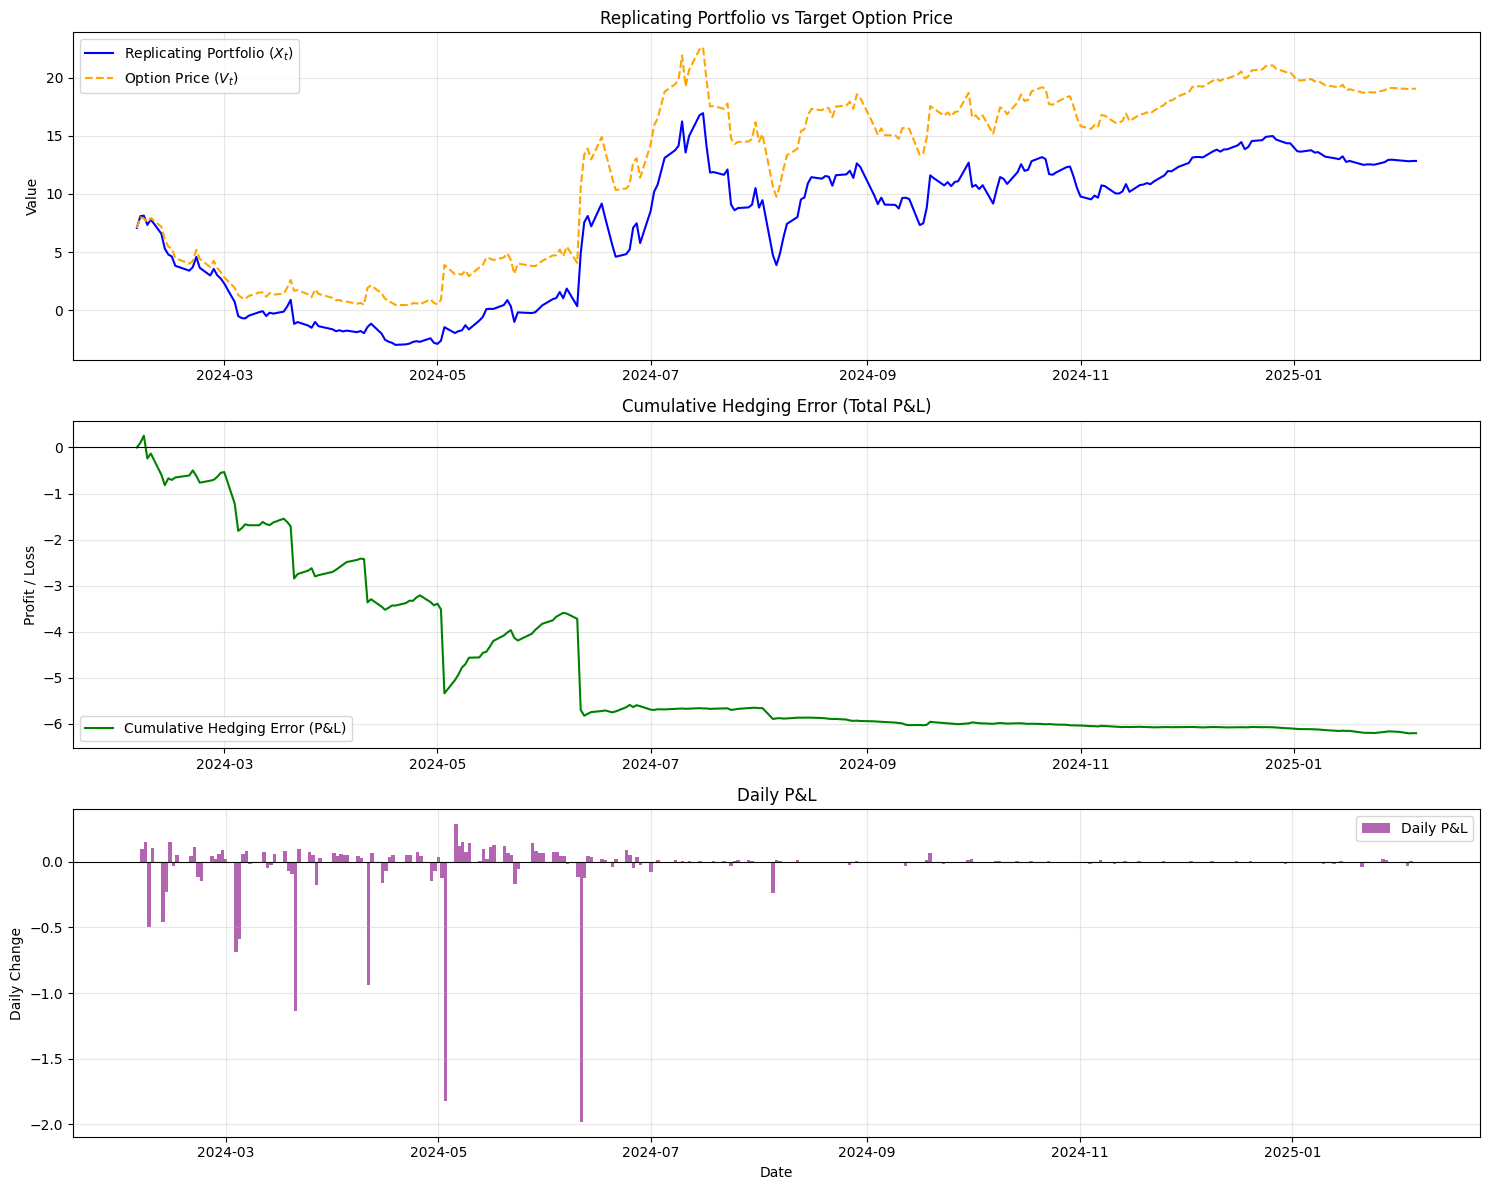

In [ ]:
plt.figure(figsize=(15, 12))

# 1. Динамика портфеля и стоимости опциона
plt.subplot(3, 1, 1)
plt.plot(results['Date'], results['Portfolio'], label='Replicating Portfolio ($X_t$)', color='blue', linewidth=1.5)
plt.plot(results['Date'], results['V'], label='Option Price ($V_t$)', color='orange', linestyle='--', linewidth=1.5)
plt.title('Replicating Portfolio vs Target Option Price')
plt.ylabel('Value')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Кумулятивный P&L (Ошибка хеджирования)
plt.subplot(3, 1, 2)
plt.plot(results['Date'], results['P&L'], label='Cumulative Hedging Error (P&L)', color='green')
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Cumulative Hedging Error (Total P&L)')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Дневной P&L (Daily P&L)
plt.subplot(3, 1, 3)
plt.bar(results['Date'], results['Daily P&L'], label='Daily P&L', color='purple', alpha=0.6, width=1.0)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
plt.title('Daily P&L')
plt.ylabel('Daily Change')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Задача 8: Разложение на компоненты

8. (2 points) Suppose we apply Black-Schoules-Merton model with time-dependend volatility without volitility recalibrartion. \
Assume we calibrate the volatility function in the model using estimates derived from a GARCH(1,1).\
Implement the decomposition of the hedging error into components (excluding the Vega component). \
Assume that the model rate is $10\%$, and the difference between the model rate and the instantenious rate $r^f_t$ is $0.5\%$. \
Plot the results.\
Explain sign of each component and factors affecting its size.

In [ ]:
# --- Основная функция из Семинара 4 ---

def simulatePortfolio(
    dates: List[date],
    spotPrice: List[float],
    volatilityOption: List[float], # Здесь передаем sigma_curr (GARCH)
    volatilityPremium: float,
    volatilityHedging: List[float],
    riskFreeRate: float,
    riskFreeRateModel: float,
    maturity: float,
    # Дополнительные параметры для Азиата
    K: float,
    start_date: date,
    sigma_L: float,
    alpha: float,
    beta: float
) -> Tuple[np.array, float]:

    """
    Modified simulatePortfolio for Geometric Asian Option without recalibration from Seminar 4.
    """

    pricingDate = dates[0]
    # strike = spotPrice[0] # Strike is passed explicitly now
    strike = K

    # T_total для формул (считаем от старта сделки)
    T_total = (maturity - start_date).days / 365.0

    callPV = []
    deltaHedging = []
    deltaOption = []
    gammaOption = []
    # Vega, Vanna, Volga исключены (занулены) по условию задачи
    vegaOption = []
    vannaOption = []
    volgaOption = []

    #port_val = []

    allDf = []

    # Накапливаемый интеграл
    Y_t = 0.0
    # Фиксируем параметры на старте (t=0)
    sigma_0 = volatilityOption[0] # Стартовая волатильность
    dt_garch=1/252 # а как надо????
    lam = np.log(1 / (alpha + beta)) / dt_garch


    #def geometric_asian_delta(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252)
    #def geometric_asian_gamma(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252)
    #def geometric_asian_call_price(S, K, T, t, r, Y_t, sigma_curr, sigma_L, alpha, beta, dt=1/252)

    for i, currentDate in enumerate(dates[:-1]):
        # Текущее время t от начала контракта
        t_current = (currentDate - start_date).days / 365.0

        # Обновляем Y_t (метод трапеций)
        if i > 0:
            dt_step = (currentDate - dates[i-1]).days / 365.0
            Y_t += 0.5 * (np.log(spotPrice[i-1]) + np.log(spotPrice[i])) * dt_step

        # Дисконт-фактор (рыночный)
        quotesTable = exp(-riskFreeRate * (currentDate - pricingDate).days / 365.)
        allDf.append(quotesTable)

        # 2. Считаем МОДЕЛЬНУЮ волатильность (детерминированный снос)
        # Это то, что модель "думала" в t=0, что будет в момент t
        sigma_sq_model = sigma_L**2 + (sigma_0**2 - sigma_L**2) * np.exp(-lam * t_current)
        sigma_model_curr = np.sqrt(sigma_sq_model)

        # 3. Используем модельную волатильность для прайсинга и греков
        # Вычисляем цену и греки
        callPV.append(geometric_asian_call_price(spotPrice[i], strike, T_total, t_current, riskFreeRateModel, Y_t, sigma_model_curr, sigma_L, alpha, beta, dt_garch))
        # Дельты
        d_h = geometric_asian_delta(spotPrice[i], strike, T_total, t_current, riskFreeRateModel, Y_t, sigma_model_curr, sigma_L, alpha, beta, dt_garch)
        d_o = d_h

        deltaHedging.append(d_h)
        deltaOption.append(d_o)

        # Гамма
        gammaOption.append(geometric_asian_gamma(spotPrice[i], strike, T_total, t_current, riskFreeRateModel, Y_t, sigma_model_curr, sigma_L, alpha, beta, dt_garch))

        # Зануляем компоненты волатильности
        vegaOption.append(0)
        vannaOption.append(0)
        volgaOption.append(0)
        #port_val.append(d_0*spotPrice[i] + )

        if currentDate == pricingDate:
            # Premium calculated at t=0
            initialHedgeValue = [geometric_asian_call_price(spotPrice[i], strike, T_total, t_current, riskFreeRateModel, Y_t, sigma_model_curr, sigma_L, alpha, beta, dt_garch)]
            optionValue = [callPV[i]]
            premiumComponent = [initialHedgeValue[0] - optionValue[0]]
            fundingComponent = [0]
            deltaComponent = [0]
            gammaComponent = [0]
            vegaComponent = [0]
            vannaComponent = [0]
            volgaComponent = [0]
        else:

            dt = (currentDate - dates[i - 1]).days / 365.

            prevDf = exp(-riskFreeRate * (dates[i - 1] - pricingDate).days / 365.)
            optionValue.append(callPV[i])
            initialHedgeValue.append(
                initialHedgeValue[i - 1]
                + deltaHedging[i - 1] * (spotPrice[i] - spotPrice[i - 1])
                + riskFreeRate * (initialHedgeValue[i - 1] - deltaHedging[i - 1] * spotPrice[i - 1]) * dt
            )
            premiumComponent.append(premiumComponent[i - 1])

            # Funding P&L: (r_market - r_model)
            fundingComponent.append(
                fundingComponent[i - 1]
                + prevDf * (riskFreeRate - riskFreeRateModel)
                * (callPV[i - 1] - deltaOption[i - 1] * spotPrice[i - 1]) * dt
            )

            # Delta P&L (Discretization error)
            deltaComponent.append(
                deltaComponent[i - 1]
                + (deltaHedging[i - 1] - deltaOption[i - 1]) * (quotesTable * spotPrice[i] - prevDf * spotPrice[i - 1])
            )

            # Gamma P&L: 0.5 * Gamma * (sigma^2*S^2*dt - dS^2)
            gammaComponent.append(
                gammaComponent[i - 1]
                + .5 * prevDf * gammaOption[i - 1]
                * (
                    volatilityOption[i - 1] ** 2 * spotPrice[i - 1] ** 2 * dt
                    - (spotPrice[i] - spotPrice[i - 1]) * (spotPrice[i] - spotPrice[i - 1])
                )
            )
            # Остальные компоненты 0
            vegaComponent.append(0)
            vannaComponent.append(0)
            volgaComponent.append(0)


    portfolio = np.array(initialHedgeValue) - np.array(optionValue) \
        - 1 / np.array(allDf) \
        * (
            np.array(premiumComponent)
            + np.array(fundingComponent)
            + np.array(deltaComponent)
            + np.array(gammaComponent)
            - np.array(vegaComponent)
            - np.array(vannaComponent)
            - np.array(volgaComponent)
        )

    # Возвращаем словарь компонент для анализа
    components = {
        'Total P&L': portfolio,
        "hedgingPortfolio": initialHedgeValue,
        "hedgingPortfolioError": portfolio - (np.array(initialHedgeValue) - np.array(optionValue)),
        "optionValue": np.array(optionValue),
        'Premium': np.array(premiumComponent),
        'Funding': np.array(fundingComponent),
        'Gamma': np.array(gammaComponent),
        'Delta': np.array(deltaComponent),
        "Vega": np.array(vegaComponent),
        "Vanna": np.array(vannaComponent),
        "Volga": np.array(volgaComponent),
        "discountFactors": np.array(allDf)
    }

    return components, optionValue[0]

In [ ]:
# Параметры контракта
K_strike = 190.0
r_model = 0.10
r_market = 0.095
start_dt = pd.to_datetime('2024-02-05')
expiry_dt = pd.to_datetime('2025-02-05')

# [FIX] Создаем trade_data, фильтруя исходный df_raw
mask = (df_raw['Date'] >= start_dt) & (df_raw['Date'] <= expiry_dt)
trade_data = df_raw.loc[mask].reset_index(drop=True)

# Теперь списки создаются корректно
dates_list = trade_data['Date'].tolist()
spot_list = trade_data['underlyingPrice'].tolist()
vol_list = trade_data['estimatedVolatility'].tolist()

# Извлекаем параметры GARCH (фиксируем их на момент начала сделки)
# Берем из первой строки отфильтрованных данных
sigma_L_val = trade_data['longRun'].iloc[0]
alpha_val = trade_data['alphas'].iloc[0]
beta_val = trade_data['betas'].iloc[0]

# Запуск симуляции
comps, v0 = simulatePortfolio(
    dates=dates_list,
    spotPrice=spot_list,
    volatilityOption=vol_list,
    volatilityPremium=vol_list[0],
    volatilityHedging=vol_list,
    riskFreeRate=r_market,
    riskFreeRateModel=r_model,
    maturity=expiry_dt,
    K=K_strike,
    start_date=start_dt,
    sigma_L=sigma_L_val,
    alpha=alpha_val,
    beta=beta_val
)

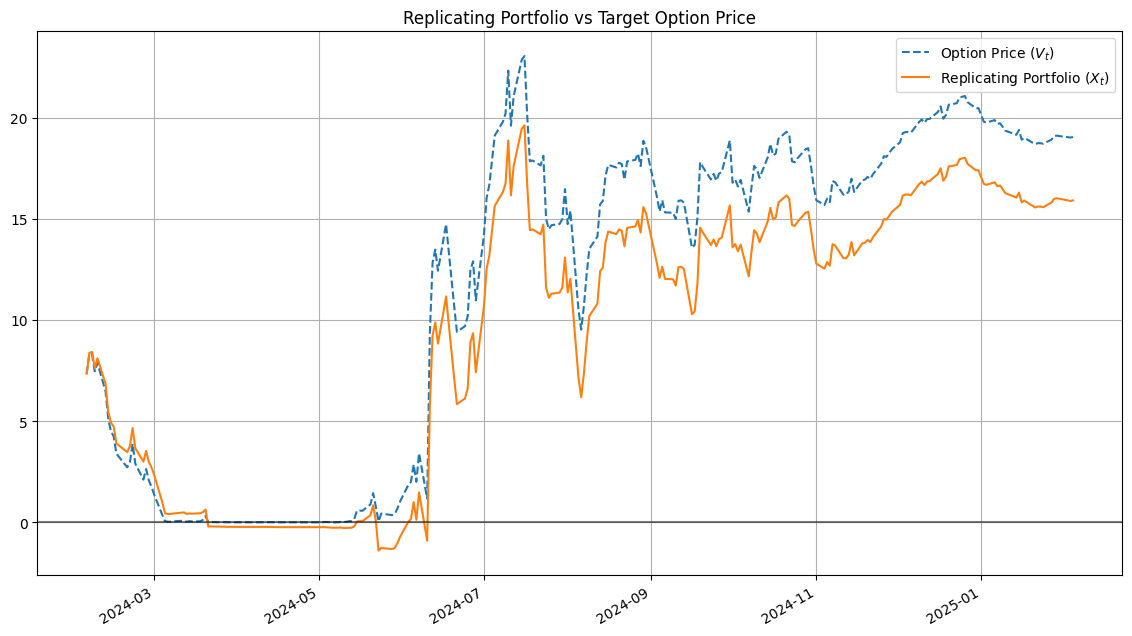

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(dates_list[:-1], comps['optionValue'], label='Option Price ($V_t$)', linestyle='--')
plt.plot(dates_list[:-1], comps['hedgingPortfolio'], label='Replicating Portfolio ($X_t$)', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.gcf().autofmt_xdate()
plt.title("Replicating Portfolio vs Target Option Price")
plt.grid(True)
plt.legend()

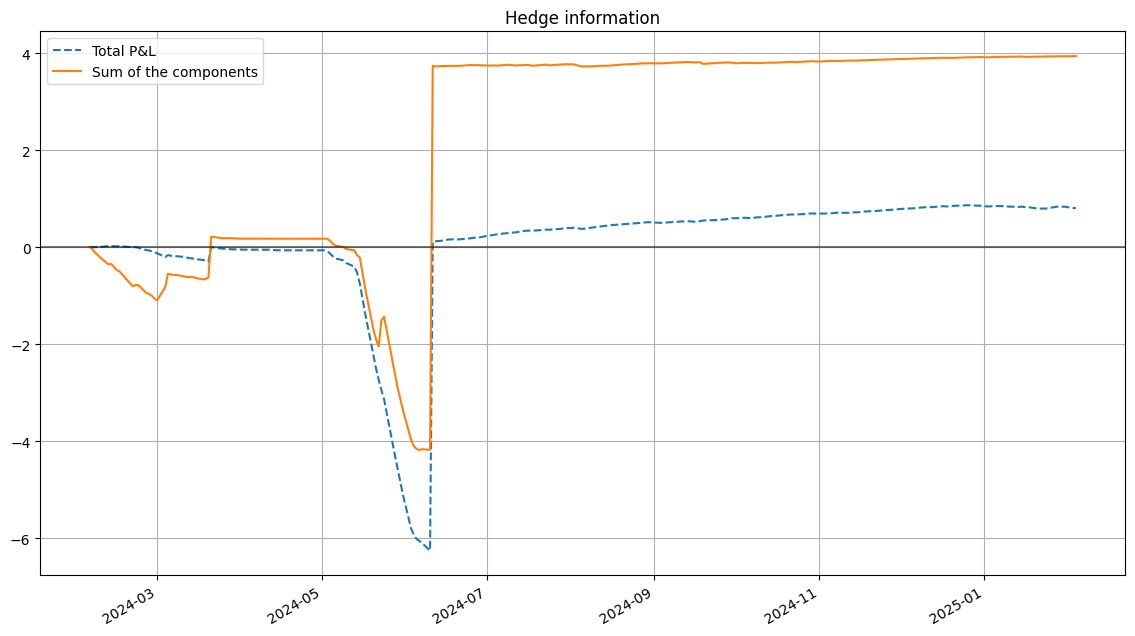

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(dates_list[:-1], comps['Total P&L'], label='Total P&L', linestyle='--')
plt.plot(dates_list[:-1], comps['hedgingPortfolioError'], label='Sum of the components', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)

plt.gcf().autofmt_xdate()
plt.title("Hedge information")
plt.grid(True)
plt.legend()

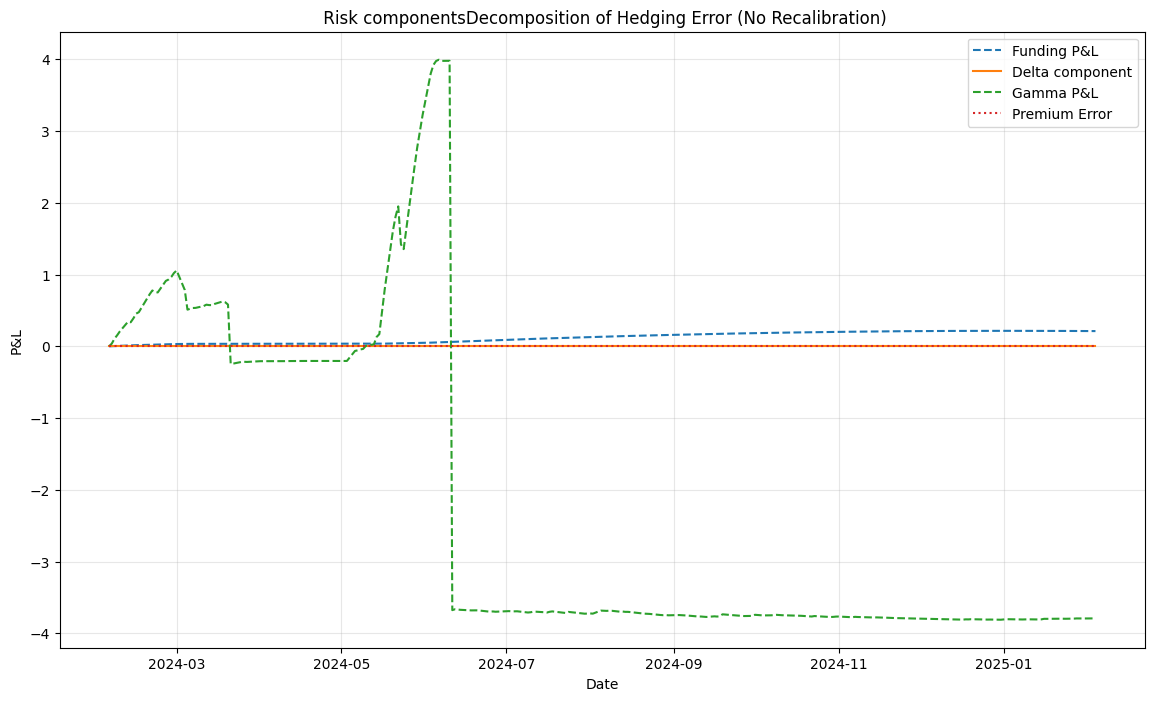

Final Total P&L: 0.8092
Final Funding P&L: 0.2121
Final Gamma P&L: -3.7932


In [ ]:
# --- Визуализация ---
plt.figure(figsize=(14, 8))
#plt.plot(dates_list[:-1], comps['Total P&L'], label='Total P&L (X_t - V_t)', color='black', linewidth=2)
plt.plot(dates_list[:-1], comps['Funding'], label='Funding P&L', linestyle='--')
plt.plot(dates_list[:-1], comps['Delta'], label='Delta component', linestyle='-')
plt.plot(dates_list[:-1], comps['Gamma'], label='Gamma P&L', linestyle='--')
plt.plot(dates_list[:-1], comps['Premium'], label='Premium Error', linestyle=':')

plt.title(' Risk componentsDecomposition of Hedging Error (No Recalibration)')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Total P&L: {comps['Total P&L'][-1]:.4f}")
print(f"Final Funding P&L: {comps['Funding'][-1]:.4f}")
print(f"Final Gamma P&L: {comps['Gamma'][-1]:.4f}")

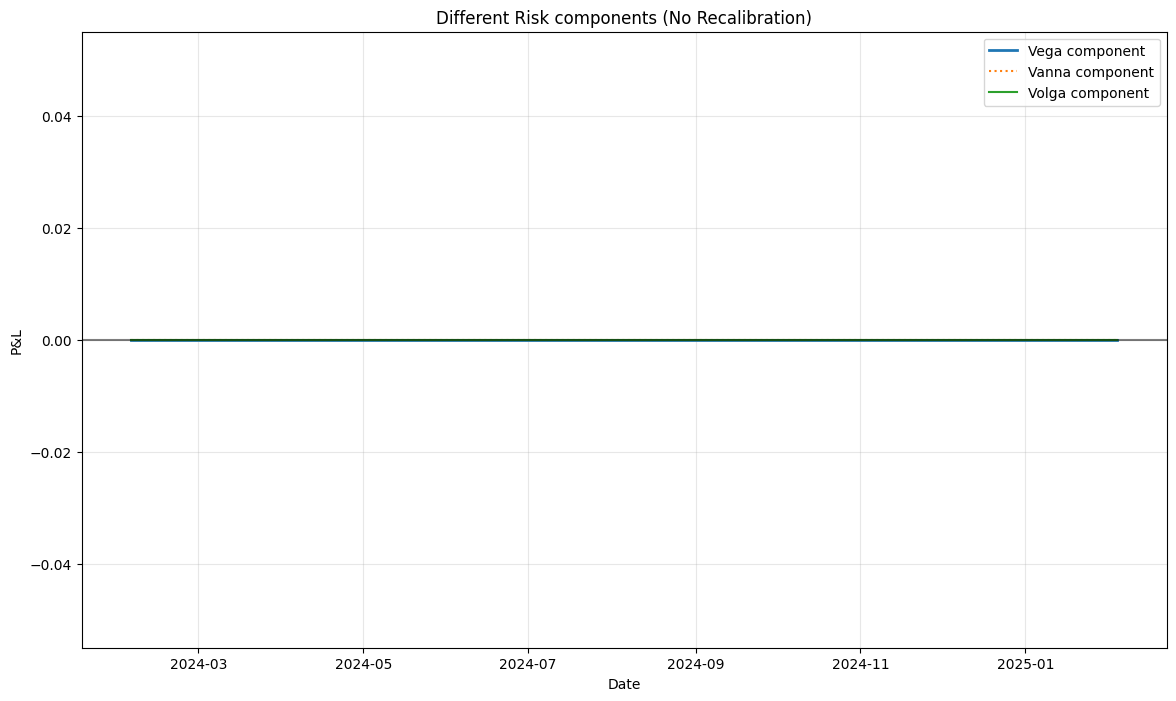

In [ ]:
# --- Визуализация ---
plt.figure(figsize=(14, 8))
plt.plot(dates_list[:-1], comps['Vega'], label='Vega component', linewidth=2)
plt.plot(dates_list[:-1], comps['Vanna'], label='Vanna component', linestyle=':')
plt.plot(dates_list[:-1], comps['Volga'], label='Volga component', linestyle='-')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)


plt.title('Different Risk components (No Recalibration)')
plt.xlabel('Date')
plt.ylabel('P&L')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Анализ компонент ошибки хеджирования

Ошибка хеджирования $Z_t = X_t - V_t$ (Стоимость портфеля $-$ Стоимость опциона) раскладывается на следующие компоненты:

#### 1. Funding component

$$
\text{Funding P\&L}_t = \int_0^t \frac{D_u}{D_t} (r_u^f - r) \left( V_u - S_u \frac{\partial V}{\partial S} \right) du
$$

* **Разница ставок:** По условию $r_{model} = 10\%$, $r^f = 9.5\%$.
$$ (r^f - r_{model}) = -0.005 < 0 $$
* **Денежная позиция (Cash):** Мы продали опцион (получили премию $V$) и купили акции для хеджирования (потратили $\Delta \cdot S$). Так как для Call-опциона (особенно в деньгах) $\Delta S > V$, наша денежная позиция $(V - \Delta S)$ является **отрицательной** (мы берем займ для покупки акций).
* **Итоговый знак:** Произведение двух отрицательных величин дает плюс.

**Экономический смысл:** Мы занимаем деньги на рынке дешевле ($9.5\%$), чем заложено в модели ценообразования опциона ($10\%$). Эта "экономия" на обслуживании долга создает положительную прибыль.

**Что влияет на размер:**
* Размер долга (зависит от moneyness опциона: чем глубже ITM, тем больше $\Delta$, тем больше долг).
* Величина спреда процентных ставок.

---

#### 2. Gamma component
$$
\text{Gamma P\&L}_t = \frac{1}{2} \int_0^t \frac{D_u}{D_t} \frac{\partial^2 V}{\partial S^2} (\sigma_{model}^2(u)S^2_u - (dS_u)^2) du
$$

В коде данный компонент реализует разницу между модельной и реализованной дисперсией:
$$ \text{Gamma P\&L}_t = \int_0^t \frac{1}{2} D_u S_u^2 \Gamma_u \left( \sigma_{model}^2(u) - \sigma_{real}^2(u) \right) \, du $$

* **Гамма ($\Gamma$):** Для Call-опциона (в том числе азиатского) $\Gamma > 0$.
* **Разница волатильностей:**
    * $\sigma_{model}$ — это прогноз GARCH, зафиксированный в момент $t=0$.
    * $\sigma_{real}$ — это фактическая волатильность рынка AAPL на траектории.
* **Наблюдение:** На графике Gamma P\&L **отрицательный**.
* **Вывод:** Это означает, что $\left( \sigma_{model}^2 - \sigma_{real}^2 \right) < 0$, то есть **реализованная волатильность оказалась выше прогнозной** ($\sigma_{real} > \sigma_{model}$).

**Экономический смысл:** Мы, как продавцы опциона (short gamma), теряем деньги, когда рынок колеблется сильнее, чем мы ожидали. При рехеджировании мы вынуждены покупать акции после роста цены и продавать после падения, фиксируя убыток на каждом шаге, который превышает временной распад (Theta) опциона.

**Факторы влияния:**
* Точность прогноза GARCH на $t=0$.
* Величина Гаммы (максимальна для опционов "на деньгах" и вблизи экспирации, хотя для азиатских опционов эффект сглажен усреднением).

---

#### 3. Delta component
$$
\text{Delta P\&L} = \int_0^t \frac{D_u}{D_t} \left( \Delta_u^h - \frac{\partial V}{\partial S} \right) (dS_u - r_u^f S_u du)
$$

Этот компонент возникает из-за того, что мы хеджируем позицию не непрерывно, а раз в день.
$$ \text{Delta P\&L} \approx \sum \left( \Delta_{hedging} - \Delta_{model} \right) dS + \text{Discretization Noise} $$
В нашем случае $\Delta_{hedging} = \Delta_{model}$, поэтому компонент представляет собой чистый шум дискретизации. Он колеблется около нуля и значительно меньше по модулю, чем эффекты от ставок и волатильности.

#### 4. Premium component
Premium-компонента нулевая, так как мы начинаем с точного значения

#### 5. Vanna, Volga, Vega component
Все нулевые, так как мы не делаем перекалибровку


## Задача 9: Подумать...

9. (2 points) Suggest which **calibration variables** can be used for a geometric Asian option in the Black-Scholes-Merton model with time-dependent volatility (estimated from GARCH(1,1)) and volatility recalibration. Provide the corresponding decomposition of the hedging error.

#### 1. Переменные калибровки (Calibration Variables)

В случае модели Блэка-Шоулза с зависящей от времени волатильностью, прогнозируемой через GARCH(1,1), и с условием перекалибровки, переменной калибровки является **текущая мгновенная волатильность** $\sigma_t$ (spot volatility).

В модели GARCH(1,1) прогноз будущей дисперсии $\sigma^2(u)$ для $u > t$ строится на основе:
1.  Долгосрочной волатильности $\sigma_L$ (константа).
2.  Параметров модели $\alpha, \beta$ (константы).
3.  **Текущей оценки дисперсии** $\sigma^2(t)$.

При перекалибровке мы обновляем $\sigma^2(t)$ на каждом шаге на основе новых рыночных данных (реализованных доходностей). Это делает параметр $\sigma$ в формуле цены опциона **стохастической переменной**, а не детерминированной функцией.

Таким образом, функция цены опциона приобретает зависимость от этого параметра:
$$ V = V(t, S_t, Y_t, \sigma_t) $$

#### 2. Декомпозиция ошибки хеджирования

Основываясь на формуле, полученной в Задаче 3, ошибка хеджирования $Z_t = X_t - V_t$ раскладывается на следующие компоненты:

$$
Z_t = \frac{Z_0}{D_t} + \underbrace{ \int_0^t \frac{D_u}{D_t} \left( \Delta_u^h - \frac{\partial V}{\partial S} \right) (dS_u - r_u^f S_u du)}_{\textbf{Delta Hedge Error}}
$$
$$
+ \underbrace{\int_0^t \frac{D_u}{D_t} (r_u^f - r) \left( V_u - S_u \frac{\partial V}{\partial S} \right) du}_{\textbf{Funding / Rate P\&L}}
$$
$$
+ \underbrace{\frac{1}{2} \int_0^t \frac{D_u}{D_t} \frac{\partial^2 V}{\partial S^2} \left(\sigma_{model}^2(u)S^2_u du - (dS_u)^2\right)}_{\textbf{Gamma P\&L}}
$$
$$
+ \underbrace{\int_0^t \frac{D_u}{D_t} \frac{\partial V}{\partial \sigma} \left( \frac{\partial \sigma_u}{\partial u} du - d\sigma_u \right)}_{\textbf{Vega / Recalibration P\&L}}
$$
$$
- \underbrace{\int_0^t \frac{D_u}{D_t} \frac{\partial^2 V}{\partial S \partial \sigma} dS_u d\sigma_u}_{\textbf{Vanna P\&L}} - \underbrace{\int_0^t \frac{1}{2} \frac{D_u}{D_t} \frac{\partial^2 V}{\partial \sigma^2} (d\sigma_u)^2}_{\textbf{Volga P\&L}}
$$

Где:
* $D_t = \exp\left(-\int_0^t r_u^f du\right)$ — дисконтный фактор по реальной ставке $r^f$.
* $r$ — модельная безрисковая ставка.
* $\Delta_u^h$ — фактическая доля актива в хеджирующем портфеле.
* $\sigma_{model}(u)$ — прогноз волатильности на момент $u$, используемый для расчета Гаммы.
* $\frac{\partial \sigma_u}{\partial u}$ — ожидаемый детерминированный дрейф волатильности в модели GARCH(1,1) (mean reversion). Согласно лекции:
$$
 \frac{\partial \sigma_u}{\partial u} = \frac{\lambda (\sigma_L^2 - \sigma_u^2)}{2 \sigma_u}, \quad \text{где } \lambda = \frac{\ln(1/(\alpha+\beta))}{\Delta t}
 $$
* $d\sigma_u$ — полное стохастическое изменение волатильности.

**Ключевое отличие от случая без перекалибровки:**
Компоненты **Vega**, **Vanna** и **Volga** теперь **не равны нулю**. Они отражают риск того, что реальная динамика волатильности $d\sigma_u$ отклонится от ожидаемого моделью дрейфа $\frac{\partial \sigma_u}{\partial u} du$, а также риски второго порядка (выпуклость и корреляция), возникающие из-за стохастичности $\sigma$.

## Forward rates

(2 points) Consider the Hull-White model for simulating the instantaneous rate. \
In the lecture, we derived the dynamics for the forward rate $F(t, S_1, S_2)$ under the risk-neutral measure. \
Consider the yield curve for $t=2022-02-16$ from the "GCurve.csv" file. \
Estimate the parameter $\kappa$ using the following calculated forward rates:
* $F(t, t+0.25, t+0.5)$,
* $F(t, t+0.5, t+0.75)$,
* $F(t, t+0.75, t+1)$,
* $F(t, t+1, t+1.25)$,
* $F(t, t+1.5, t+1.75)$,
* $F(t, t+2, t+2.25)$,
* $F(t, t+3, t+3.25)$,
* $F(t, t+5, t+5.25)$,
* $F(t, t+10, t+10.25)$,
* $F(t, t+15, t+15.25)$,
* $F(t, t+25, t+25.25)$.

Use linear interpolation between the points on the curve, apply the Russian holiday calendar, and use Actual365 as the day count convention. The analysis also assumes simple interest rate.

### Теоретическая справка: Оценка параметра $\kappa$ в модели Hull-White

В модели Халла-Уайта мгновенная процентная ставка $r_t$ подчиняется стохастическому дифференциальному уравнению:
$$dr_t = [\theta(t) - \kappa r_t]dt + \sigma(t) d\tilde{W}_t$$
где:
* $\kappa$ — скорость возврата к среднему (mean reversion),
* $\sigma(t)$ — волатильность короткой ставки.

**Динамика форвардной ставки**

Рассмотрим простую форвардную ставку $F(t, S_1, S_2)$ для периода $[S_1, S_2]$ длиной $\delta = S_2 - S_1$. Она связана с ценами дисконтных облигаций $P(t, T)$ соотношением:
$$1 + \delta F(t, S_1, S_2) = \frac{P(t, S_1)}{P(t, S_2)}$$

Согласно Лекции 7, динамика этой ставки в модели Халла-Уайта имеет вид:
$$dF(t, S_1, S_2) = (\dots)dt + \Sigma_F(t, S_1, S_2) dW_t$$
где коэффициент диффузии (мгновенная волатильность ставки) равен:
$$\Sigma_F(t, S_1, S_2) = \left( F(t, S_1, S_2) + \frac{1}{\delta} \right) \underbrace{\sigma(t) \frac{1 - e^{-\kappa \delta}}{\kappa}}_{(1)} e^{-\kappa(S_1 - t)}$$


In [ ]:
!pip install holidays_ru
!pip install exchange_calendars

In [ ]:
import holidays_ru
from datetime import date, timedelta
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from typing import Optional, Tuple
import QuantLib as ql

# --- Класс Calendar (из Seminar 7) ---
class Calendar:
    def __init__(
        self,
        name: Optional[str] = None,
        holidays: Optional[Tuple[date, ...]] = None
    ):
        if name is not None and holidays is not None:
            raise ValueError("Only one of 'name' and 'holidays' parameters must be not None.")

        if name is not None:
            if name == "Russia":
                self.__implementation = lambda day: not holidays_ru.is_holiday(day)
            else:
                raise NotImplementedError(f"Calendar '{name}' is not implemented.")
        elif holidays is not None:
             self.__implementation = lambda day: day not in holidays

    def isBusinessDay(self, day: date) -> bool:
        if day.weekday() >= 5:
            return False
        return self.__implementation(day)

    def advance(self, start: date, dayToShift: int) -> date:
        return start + timedelta(days=dayToShift)

    def getNextDay(self, start: date) -> date:
        result = self.advance(start, 1)
        while not self.isBusinessDay(result):
            result = self.advance(result, 1)
        return result

# --- Функции конвенций ---

def Actual365(startDate: date, endDate: date) -> float:
    return (endDate - startDate).days / 365.0

def getEndDateFromActual365(dayFraction: float, startDate: date, calendar: Calendar) -> date:
    days_to_shift = int(365 * dayFraction)
    endDate = calendar.advance(startDate, days_to_shift)
    if not calendar.isBusinessDay(endDate):
        return calendar.getNextDay(endDate)
    return endDate

# --- Функция калибровки ---

def hw_vol_func(tau, sigma, kappa, c):
    return sigma * np.exp(-kappa * tau) + c


In [ ]:
# Загружаем данные
try:
    g = pd.read_csv("GCurve.csv")
    g["date"] = pd.to_datetime(g["date"])
except FileNotFoundError:
    print("Ошибка: Файл GCurve.csv не найден. Загрузите его в среду выполнения.")

# Дата оценки
t0_ts = pd.Timestamp("2022-02-16")
t0_date = t0_ts.date() # Конвертируем в date для работы с Calendar
row = g.loc[g["date"] == t0_ts].iloc[0]

# Строим интерполятор для ставок (Zero Coupon Curve)
# Берем все колонки кроме служебных как сроки (T)
cols = [c for c in g.columns if c not in ("Unnamed: 0", "date")]
T_curve = np.array(cols, float)
R_curve = np.array([row[str(t)] for t in T_curve], float) / 100.0 # Делим на 100, чтобы получить доли

# Линейная интерполяция ставок
zc = interp1d(T_curve, R_curve, kind="linear", fill_value="extrapolate")

In [ ]:
try:
    rus_cal = Calendar(name="Russia")
except NameError:
    print("ОШИБКА: Класс Calendar не найден. Запустите первую ячейку ноутбука!")
    class Calendar: pass

# Интервалы из задания: F(t, T1, T2)
intervals = [
    (0.25, 0.50), (0.50, 0.75), (0.75, 1.00), (1.00, 1.25),
    (1.50, 1.75), (2.00, 2.25), (3.00, 3.25), (5.00, 5.25),
    (10.00, 10.25), (15.00, 15.25), (25.00, 25.25)
]

tau_list = []  # Время до начала форварда (x для графика)
F_rates = []   # Значение форвардной ставки (y для графика)

for start_y, end_y in intervals:
    # Считаем сроки в годах (Convention Act/365)
    d1_date = getEndDateFromActual365(start_y, t0_date, rus_cal)
    d2_date = getEndDateFromActual365(end_y, t0_date, rus_cal)

    d1 = pd.Timestamp(d1_date)
    d2 = pd.Timestamp(d2_date)

    # Считаем сроки (Actual/365)
    tau1 = (d1 - t0_ts).days / 365.0
    tau2 = (d2 - t0_ts).days / 365.0
    dt = tau2 - tau1

    # Получаем ставки R(t) из кривой для этих сроков
    r1 = zc(tau1)
    r2 = zc(tau2)

    # Считаем Дисконт-факторы (P)
    # В условии сказано: "assumes simple interest rate"
    P1 = 1.0 / (1.0 + r1 * tau1)
    P2 = 1.0 / (1.0 + r2 * tau2)

    # Считаем простую форвардную ставку из дисконт-факторов
    F = (P1 / P2 - 1.0) / dt

    tau_list.append(tau1)
    F_rates.append(F)

# Преобразуем в массивы numpy для фиттинга
x_data = np.array(tau_list)
y_data = np.array(F_rates)

CALIBRATION RESULTS (2022-02-16):
Kappa (Mean Reversion Speed): 0.130414
Long-term rate level: 2.6112%


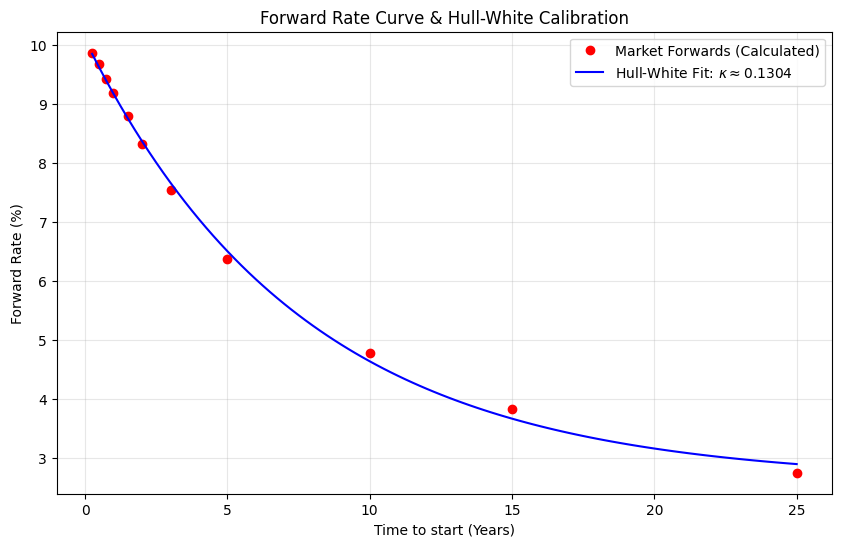

In [ ]:
# Теоретическая функция зависимости форвардной ставки от времени
# F(t) = f_inf + A * exp(-kappa * t)
def hw_forward_curve(t, f_inf, A, kappa):
    return f_inf + A * np.exp(-kappa * t)

# Начальные приближения для оптимизатора
# f_inf = последняя точка, A = разница между первой и последней, kappa = 0.1
p0 = [y_data[-1], y_data[0] - y_data[-1], 0.1]

bounds = ([0.0, -np.inf, 0.0], [np.inf, np.inf, np.inf])

try:
    popt, pcov = curve_fit(hw_forward_curve, x_data, y_data, p0=p0, bounds=bounds)

    f_inf_est, A_est, kappa_est = popt

    print("="*50)
    print(f"CALIBRATION RESULTS (2022-02-16):")
    print(f"Kappa (Mean Reversion Speed): {kappa_est:.6f}")
    print(f"Long-term rate level: {f_inf_est:.4%}")
    print("="*50)
    plt.figure(figsize=(10, 6))
    plt.plot(x_data, y_data * 100, 'ro', label='Market Forwards (Calculated)')

    x_grid = np.linspace(min(x_data), max(x_data), 100)
    y_fit = hw_forward_curve(x_grid, *popt) * 100
    plt.plot(x_grid, y_fit, 'b-', label=rf'Hull-White Fit: $\kappa \approx {kappa_est:.4f}$')

    plt.xlabel('Time to start (Years)')
    plt.ylabel('Forward Rate (%)')
    plt.title('Forward Rate Curve & Hull-White Calibration')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

except Exception as e:
    print(f"Ошибка оптимизации: {e}")
    if "name 'getEndDateFromActual365' is not defined" in str(e):
        print("Проблема с календарем!")